# LightGCN

In [1]:
import torch
import torch.nn as nn 

## Data

In [2]:
from gcn.data import read_data_ml100k, split_data_ml100k, load_data_ml100k
ratings_df, num_users, num_items = read_data_ml100k("./data/ml-latest-small")
train_data, test_data = split_data_ml100k(ratings_df, num_users, 'seq-aware', test_ratio=0.1)
_, _, _, train_candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit"
) # train_candidates is a dict of {user: [items]}
users_train, items_train, ratings_train, _ = load_data_ml100k(
    train_data, num_users, num_items, feedback="explicit"
) # train_candidates is a dict of {user: [items]}
_, _, _, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit"
) # train_candidates is a dict of {user: [items]}
users_test, items_test, ratings_test, _ = load_data_ml100k(
    test_data, num_users, num_items, feedback="explicit"
) # test_candidates is a dict of {user: [items]}

In [3]:
len(train_data)

100226

In [4]:
len(test_data)

610

In [5]:
user_dim = torch.LongTensor(users_train)
item_dim = torch.LongTensor(items_train)
first_sub = torch.stack([user_dim, item_dim + num_users])
second_sub = torch.stack([item_dim + num_users, user_dim])
index = torch.cat([first_sub, second_sub], dim=1)
data = torch.ones(index.size(-1)).int()
Graph = torch.sparse.IntTensor(
    index, data,
    torch.Size([num_users+num_items, num_users+num_items])
)
dense = Graph.to_dense()
"""
A =
    |I,   R|
    |R^T, I|
"""
D = torch.sum(dense, dim=1).float()
D[D==0.] = 1. # avoid dividing by zero
D_sqrt = torch.sqrt(D).unsqueeze(dim=0)
dense = dense/D_sqrt
dense = dense/D_sqrt.t()
"""
A = D^{-1/2} @ A @ D^{-1/2}
"""
index = dense.nonzero()
data  = dense[dense >= 1e-9]
assert len(index) == len(data)
Graph = torch.sparse.FloatTensor(
    index.t(), data,
    torch.Size([num_users+num_items, num_users+num_items])
) # Graph is a symmetric matrix now

/tmp/ipykernel_43780/2863010693.py:7: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  Graph = torch.sparse.IntTensor(


In [6]:
class ML100KPoint(torch.utils.data.Dataset):
    def __init__(self, users, items, ratings):
        assert len(users) == len(items)
        self.users = users
        self.items = items
        self.ratings = ratings

    def __getitem__(self, index):
        return (self.users[index], self.items[index], self.ratings[index])

    def __len__(self):
        return len(self.users)

In [7]:
batch_size = 1024
trainset = ML100KPoint(users_train, items_train, ratings_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
len(train_loader)

98

## Model Config

In [9]:
from gcn.models import LightGCN
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = LightGCN(num_users, num_items, n_factors, Graph.to(device))
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

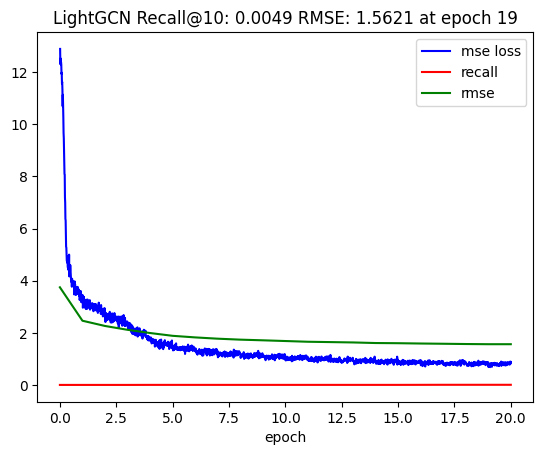

LightGCN Recall@10: 0.0049 RMSE: 1.5621 at epoch 19


In [10]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'LightGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'LightGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

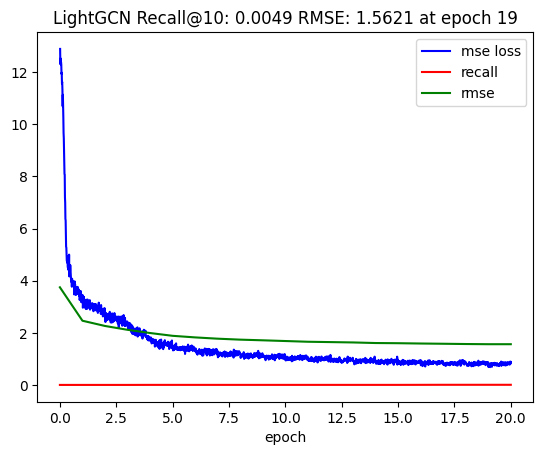

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'LightGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [12]:
recall_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.003278688524590164,
 0.004918032786885246,
 0.004918032786885246,
 0.004918032786885246,
 0.004918032786885246]

In [13]:
rmse_list

[3.7455985624060464,
 2.4628115345585497,
 2.2617780977411623,
 2.114560683055518,
 1.9909633091487309,
 1.8839334024252448,
 1.8230268681231234,
 1.7736981574258923,
 1.7369467423904739,
 1.7115478123843806,
 1.6841537358566039,
 1.6562676338840532,
 1.6430320883535339,
 1.6297308940724282,
 1.6071210466146226,
 1.600310864647907,
 1.588541158040283,
 1.5793279463140855,
 1.5689874628902123,
 1.5620478929657768,
 1.5620552956028786]

In [14]:
# max(recall_list), min(rmse_list) 
print(f'LightGCN Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'LightGCN Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

LightGCN Max Recall@10: 0.0049 at epoch 17
LightGCN Min RMSE: 1.5620 at epoch 19
